In [11]:
import sys, os, platform, inspect

def get_current_file_path():
    # script filename (usually with path)
    filename = inspect.getfile(inspect.currentframe())
    # script directory
    path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    return filename, path


if platform.system() == 'Linux': # Colab setting
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = '/content/gdrive/My Drive/Colab Notebooks/kaggle'
else:
    _, path = get_current_file_path()    

sys.path.insert(0, path)
os.chdir(path)

sys.path.append(path + '/t-SNE')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
transform = transforms.ToTensor()
dset_train = torchvision.datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
dset_test = torchvision.datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

factor = 0.9
train_len = int(len(dset_train) * factor)
valid_len = len(dset_train)  - train_len

dset_train, dset_valid = data.random_split(dset_train, [train_len, valid_len])

batch_size = 16

dloader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dloader_valid = data.DataLoader(dset_valid, batch_size=batch_size, shuffle=True)

tensor([8, 4, 7, 2, 4, 6, 2, 0, 3, 0, 0, 6, 1, 9, 6, 4])


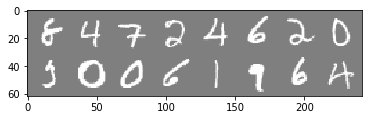

In [14]:
x, y = next(iter(dloader_train))
plt.imshow((torchvision.utils.make_grid(x).numpy().transpose(1, 2, 0)+1)/2, cmap='gray')
print(y)

In [0]:
class Save:
    def __init__(self):
        self.ℓ_min = np.inf

    def __call__(self, ℓ, model, verbose=True):
        if ℓ < self.ℓ_min:
            self.ℓ_min = ℓ
            if verbose:
                print(f' ==> saving model')
            torch.save(model.state_dict(), 'model.pt')


def train_AE(model, epochs, ℓ_fn, optimizer, dloader_train, device):
    save_model = Save()
    model.train()
    for i_epoch in range(1, epochs+1):
        loss_val = []
        for x, _ in dloader_train:
            x = x.to(device)
            optimizer.zero_grad()
            ℓ = ℓ_fn(model(x), x)/torch.norm(x)
            ℓ.backward()
            optimizer.step()
            loss_val.append(ℓ.data.cpu().item())
        print(f'Epoch {i_epoch} loss: {sum(loss_val)/len(loss_val):.5f}')
        save_model(sum(loss_val)/len(loss_val), model)

In [0]:
def conv2d_layer(c_in, c_out, k=3, padding=1, bn=True, relu=nn.ReLU()):
    seq = [nn.Conv2d(c_in, c_out, k, padding=padding), relu]
    if bn:
        seq.append(nn.BatchNorm2d(c_out))
    return(nn.Sequential(*seq))

Encoder = lambda: nn.Sequential(
    conv2d_layer(1, 16),
    conv2d_layer(16, 32), 
    nn.MaxPool2d(2),
    conv2d_layer(32, 64), 
    nn.MaxPool2d(2),
    conv2d_layer(64, 128, padding=0),
    nn.Conv2d(128, 256, 2, stride=2),
#    nn.AvgPool2d(2)
)

Decoder = lambda: nn.Sequential(
    nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
    nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
    nn.Conv2d(16, 1, 5), nn.Sigmoid())

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AE().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_AE(model, 20, nn.MSELoss(), optimizer, dloader_train, device)

AE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

tensor([8, 4, 7, 2, 4, 6, 2, 0, 3, 0, 0, 6, 1, 9, 6, 4])


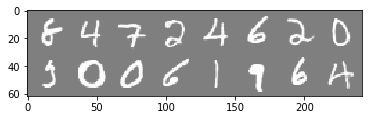

In [18]:
x_gpu = x.to(device)
plt.imshow((torchvision.utils.make_grid(model(x_gpu)).cpu().detach().numpy().transpose(1, 2, 0)+1)/2, cmap='gray')
print(y)

In [0]:
def foo(x):
    return nn.AvgPool2d(2)(model.encoder(x.to(device))).squeeze().cpu().detach().numpy()

In [20]:
foo(x).shape

(16, 256)

In [0]:
X_valid_bottleneck, y_valid = [], []
for x, y in dloader_valid:
    X_valid_bottleneck.append(foo(x))
    y_valid.append(y)

X_valid_bottleneck = np.vstack(X_valid_bottleneck)
y_valid = np.concatenate(y_valid)


X_train_bottleneck, y_train = [], []
for x, y in dloader_train:
    X_train_bottleneck.append(foo(x))
    y_train.append(y)

X_train_bottleneck = np.vstack(X_train_bottleneck)
y_train = np.concatenate(y_train)



In [22]:
print(X_valid_bottleneck.shape, y_valid.shape)
print(X_train_bottleneck.shape, y_train.shape)


(6000, 256) (6000,)
(54000, 256) (54000,)


In [0]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
dtree_model = DecisionTreeClassifier(max_depth = 2000).fit(X_train_bottleneck, y_train) 
ŷ = dtree_model.predict(X_valid_bottleneck) 
(ŷ == y_valid).astype(np.int).mean()

0.6508333333333334

In [27]:
dtree_model = DecisionTreeRegressor(max_depth = 200).fit(X_train_bottleneck, y_train) 
ŷ = dtree_model.predict(X_valid_bottleneck) 
(ŷ == y_valid).astype(np.int).mean()

0.5986666666666667

In [31]:
dtree_model = GradientBoostingClassifier().fit(X_train_bottleneck, y_train)
ŷ = dtree_model.predict(X_valid_bottleneck) 
(ŷ == y_valid).astype(np.int).mean()

0.862

In [32]:
ŷ

array([8, 2, 7, ..., 8, 8, 6])

In [0]:
def train_classifier(model, epochs, ℓ_fn, optimizer, dloader_train, dloader_valid, device):
    save_model = Save()
    for i_epoch in range(1, epochs+1):
        for x, y in dloader_train:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            ℓ_fn(model(x), y).backward()
            optimizer.step()
        model.eval()
        loss_val = []
        loss_acc = []
        for x, y in dloader_valid:
            x, y = x.to(device), y.to(device)
            ŷ = model(x)
            ℓ = ℓ_fn(ŷ, y)
            loss_val.append(ℓ.cpu().item())
            loss_acc.append((y == ŷ.argmax(dim=1)).to(torch.float).mean())
        model.train()
        print(f'Epoch {i_epoch} loss: {sum(loss_val)/len(loss_val):.5f}, accuracy: {sum(loss_acc)/len(loss_acc):.5f}')
        save_model(sum(loss_val)/len(loss_val), model)

In [0]:
class Model(nn.Module):
    def __init__(self, ae):
        super(Model, self).__init__()

        self.features = ae.encoder
        for param in self.features.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(256 * 2**2, 256),
            nn.Tanh(), nn.Dropout(),
            nn.Linear(256, 64),
            nn.Tanh(), nn.Dropout(),
            nn.Linear(64, 10))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model_classifier = Model(model).to(device)
print(model_classifier)
lr = 0.0002
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_classifier(model_classifier, 50, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

KeyboardInterrupt: ignored